In [1]:
import json
import random
import re
from pathlib import Path
from typing import List, Dict, Set, Tuple

import pandas as pd
from datasets import load_dataset, Dataset, DatasetDict
from tqdm.auto import tqdm

# --- Path and Directory Definitions ---

def find_project_root(marker: str = ".git") -> Path:
    """Traverse upwards to find the project root, marked by the git repository."""
    current_path = Path.cwd().resolve()
    while current_path != current_path.parent:
        if (current_path / marker).exists():
            return current_path
        current_path = current_path.parent
    raise FileNotFoundError(f"Could not find project root. Marker '{marker}' not found.")

# --- Global Constants and Paths ---
PROJECT_ROOT = find_project_root()
DATA_DIR = PROJECT_ROOT / 'data'
OUTPUT_DIR = DATA_DIR / "sft-datasets/july-25-dataset"
PROCESSED_TEMPLATE_DIR = DATA_DIR / "template-generated-processed"

# --- Ensure output directory exists ---
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# --- Configuration ---
# Seed for reproducibility of shuffling and sampling
RANDOM_SEED = 42

# Define the number of core problems to use as a base
NUM_CONCEPTUAL_PROBLEMS = 1000
NUM_COMPUTATIONAL_PROBLEMS = 1000

print(f"Project root: {PROJECT_ROOT}")
print(f"Dataset output directory: {OUTPUT_DIR}")
print(f"Random seed set to: {RANDOM_SEED}")

# --- Load Catalog of Programmatically generated Computational Errors ---
# This catalog points to individual JSON files with generated flawed solutions.
PROGRAMMATIC_COMPUTATIONAL_DIR = DATA_DIR / "computational-errors-generated"
PROGRAMMATIC_CATALOG_PATH = PROGRAMMATIC_COMPUTATIONAL_DIR / "computational_error_catalog.csv"

# --- Load manually generated conceptual/computational errors ---
# This file contains the final, human-approved conceptual/computational error text and explanations.
MANUAL_ERRORS_CSV_PATH = DATA_DIR / "manually_generated_errors_final.csv"

# --- Load Original GSM8K Dataset for 'Correct' examples and problem text ---
GSM8K_DATASET: Dataset = load_dataset("gsm8k", "main")["train"]

# --- Loading and Basic Validation ---
# 1. Programmatic Computational Errors Catalog
programmatic_comp_df = pd.read_csv(PROGRAMMATIC_CATALOG_PATH)
print(f"Loaded {len(programmatic_comp_df):,} records from programmatic computational error catalog.")
programmatic_comp_df.dropna(subset=["erroneous_line_number"], inplace=True)
print(f"Programmatic error records after dropping missing line numbers: {len(programmatic_comp_df):,}")

# 2. Manually Generated Conceptual/Computational Errors
manual_errors_df = pd.read_csv(MANUAL_ERRORS_CSV_PATH)
print(f"Loaded {len(manual_errors_df):,} records from manually validated errors CSV.")
manual_errors_df.dropna(subset=["erroneous_line_number"], inplace=True)
print(f"Manual error records after dropping missing line numbers: {len(manual_errors_df):,}")

Project root: /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math
Dataset output directory: /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math/data/sft-datasets/july-25-dataset
Random seed set to: 42
Loaded 22,623 records from programmatic computational error catalog.
Programmatic error records after dropping missing line numbers: 21,952
Loaded 1,963 records from manually validated errors CSV.
Manual error records after dropping missing line numbers: 1,740


In [2]:
# --- Tier Definition Functions ---
def has_computational_division(solution_text: str):
    """Checks if a solution text contains a division operation."""
    pattern = re.compile(r'/\s*\d')
    return bool(pattern.search(solution_text))


def has_float(solution_text: str):
    """Checks if a solution text contains a float value."""
    pattern = re.compile(r'(?<!\d)\.\d+|\d+\.\d+')
    return bool(pattern.search(solution_text))


def is_symbolic(solution_text: str):
    """Checks if a solution text uses symbolic algebra (e.g., 'Let x...')."""
    pattern = re.compile(r'^Let [a-zA-Z] ', re.MULTILINE)
    return bool(pattern.search(solution_text))


def mutually_disjoint_tiers(dataset: Dataset):
    """
    Categorizes all problems in the dataset into mutually disjoint tiers
    based on the mathematical operations present in their solution text.
    """
    tiers = {}
    symbolic_set = {idx for idx, sample in enumerate(dataset) if is_symbolic(sample.get("answer", ""))}
    non_symbolic_indices = [idx for idx in range(len(dataset)) if idx not in symbolic_set]
    
    tiers["tier1"] = sorted([idx for idx in non_symbolic_indices if not has_float(dataset[idx].get("answer", "")) and not has_computational_division(dataset[idx].get("answer", ""))])
    tiers["tier2"] = sorted([idx for idx in non_symbolic_indices if has_float(dataset[idx].get("answer", "")) and not has_computational_division(dataset[idx].get("answer", ""))])
    tiers["tier3"] = sorted([idx for idx in non_symbolic_indices if not has_float(dataset[idx].get("answer", "")) and has_computational_division(dataset[idx].get("answer", ""))])
    tiers["tier4"] = sorted([idx for idx in non_symbolic_indices if has_float(dataset[idx].get("answer", "")) and has_computational_division(dataset[idx].get("answer", ""))])
    tiers["tier5"] = sorted(list(symbolic_set))
    return tiers

TIER_LISTS = mutually_disjoint_tiers(GSM8K_DATASET)
print("Tier definitions loaded.")

Tier definitions loaded.


In [3]:
def add_tier_column(df, tier_lists):
    """
    Adds a 'tier' column to the dataframe based on the TIER_LISTS dictionary.
    
    Args:
        df: DataFrame containing an 'index' column
        tier_lists: Dictionary mapping tier names to lists of indices
        
    Returns:
        DataFrame with added 'tier' column
    """
    # Create a reverse mapping from index to tier
    index_to_tier = {}
    for tier_name, indices in tier_lists.items():
        for idx in indices:
            index_to_tier[idx] = tier_name
    
    # Map each index to its tier
    df['tier'] = df['index'].map(index_to_tier)
    
    # Handle any indices not found in tier lists
    missing_tiers = df['tier'].isna().sum()
    if missing_tiers > 0:
        print(f"Warning: {missing_tiers} indices could not be mapped to tiers")
        df['tier'] = df['tier'].fillna('unknown')
    
    return df

# Add tier column to manual_errors_df
manual_errors_df = add_tier_column(manual_errors_df, TIER_LISTS)
print("Added tier column to manual_errors_df")
print(manual_errors_df['tier'].value_counts())

# drop rows with 'tier5' as they are symbolic and not needed for this task
manual_errors_df = manual_errors_df[manual_errors_df['tier'] != 'tier5']
print(f"Manual error records after dropping 'tier5': {len(manual_errors_df):,}")
print(manual_errors_df['tier'].value_counts())

Added tier column to manual_errors_df
tier
tier3    732
tier1    646
tier2    209
tier4     97
tier5     56
Name: count, dtype: int64
Manual error records after dropping 'tier5': 1,684
tier
tier3    732
tier1    646
tier2    209
tier4     97
Name: count, dtype: int64


In [4]:
def sanitize_commas(text: str) -> str:
    """Removes comma separators from numbers to prevent model artifacts."""
    return re.sub(r'(\d),(\d)', r'\1\2', text)


def sanitize_text(text: str) -> str:
    """
    Replaces a comprehensive set of problematic Unicode characters with their
    ASCII equivalents to prevent model generation and string parsing errors.
    """
    if not isinstance(text, str):
        return ""
        
    replacements = {
        "\u2212": "-",  # Minus Sign
        "\u00d7": "*",  # Multiplication Sign
        "\u00f7": "/",  # Division Sign
        "\u22c5": "*",  # Dot Operator
        "\u201c": '"',  # Left Double Quotation Mark
        "\u201d": '"',  # Right Double Quotation Mark
        "\u2018": "'",  # Left Single Quotation Mark
        "\u2019": "'",  # Right Single Quotation Mark
        "\u2014": "-",  # Em Dash
        "\u2013": "-",  # En Dash
        "\u2026": "...",# Horizontal Ellipsis
        "\u00a0": " ",  # No-Break Space
    }
    for uni, ascii_char in replacements.items():
        text = text.replace(uni, ascii_char)
    return text


def clean_and_split_solution(raw_text: str) -> Tuple[str, str | None]:
    """
    Takes a raw solution text, sanitizes it, and separates the reasoning
    lines from the final answer line.
    
    Returns:
        A tuple containing (cleaned_reasoning_text, final_answer_string).
        final_answer_string is None if not found.
    """
    if not isinstance(raw_text, str):
        return "", None
        
    # 1. Sanitize all characters first
    sanitized_text = sanitize_text(raw_text)
    
    # 2. Remove calculator annotations
    text_no_annotations = re.sub(r'<<.*?>>', '', sanitized_text)
    
    # 3. Remove comma separators from numbers
    text_no_commas = sanitize_commas(text_no_annotations)
    
    lines = text_no_commas.split('\n')
    final_answer = None
    
    # 4. Find and extract the final answer line
    if lines and re.match(r'^\s*####\s*.*$', lines[-1]):
        final_answer_line = lines.pop().strip()
        # Extract just the number part after ####
        match = re.search(r'####\s*(.*)', final_answer_line)
        if match:
            final_answer = match.group(1).strip()

    # 5. Process the remaining reasoning lines
    cleaned_lines = [line.strip() for line in lines if line.strip()]
    reasoning_text = '\n'.join(cleaned_lines)
    
    return reasoning_text, final_answer


def convert_solution_to_json_str(cleaned_reasoning: str, final_answer: str | None) -> str:
    """
    Takes cleaned reasoning text and a final answer, and converts them into
    a single JSON-formatted string.
    """
    lines = cleaned_reasoning.split('\n')
    solution_dict = {f"L{i+1}": line for i, line in enumerate(lines) if line}
    
    if final_answer is not None:
        solution_dict["FA"] = final_answer
        
    return json.dumps(solution_dict, indent=2)



In [5]:
# print 5 randomly chosen samples from GSM8K_DATASET
print("Sample GSM8K problems:")
random_indices = random.sample(range(len(GSM8K_DATASET)), 5)
for idx in random_indices:
    sample = GSM8K_DATASET[idx]
    print(f"### Question {idx}:")
    print(sample['question'])
    print()
    print("### Original, raw answer:")
    print(sample['answer'])
    print()

    # Clean and split the solution
    reasoning, final_answer = clean_and_split_solution(sample['answer'])
    solution_str = convert_solution_to_json_str(reasoning, final_answer)
    print("### Cleaned solution JSON:")
    print(solution_str)
    print("-" * 80)

Sample GSM8K problems:
### Question 3123:
Madeline wants to drink 100 ounces of water in a day. Her water bottle can hold 12 ounces of water. She refills her water bottle 7 times. How much more water does she need to drink?

### Original, raw answer:
She has already had 12*7 =<<12*7=84>>84 ounces of water.
She needs to drink 100-84 = <<100-84=16>>16 more ounces to make it to 100 ounces.
#### 16

### Cleaned solution JSON:
{
  "L1": "She has already had 12*7 =84 ounces of water.",
  "L2": "She needs to drink 100-84 = 16 more ounces to make it to 100 ounces.",
  "FA": "16"
}
--------------------------------------------------------------------------------
### Question 2350:
For Roger's phone to function optimally, he can have a maximum of 50 apps on his phone. However, the recommended number of apps is 35. If Roger has twice the recommended number of apps, how many apps must he delete for his phone to function optimally again?

### Original, raw answer:
Roger has 35 x 2 = <<35*2=70>>70 ap

In [6]:
# System message for all samples
SYSTEM_MESSAGE = """You are a mathematical solution verifier. Your task is to analyze a given math problem and its step-by-step solution, then determine if the solution is correct or contains errors.

## Input Format:
- **Question**: A math word problem
- **Answer**: A JSON object where:
  - "L1", "L2", "L3", etc. represent sequential reasoning steps
  - "FA" represents the final answer

## Your Task:
Classify the solution into one of three categories:

1. **"correct"**: The solution is mathematically sound and arrives at the correct answer
2. **"conceptual_error"**: The solution contains a logical or conceptual mistake (wrong approach, incorrect formula, misunderstanding the problem)
3. **"computational_error"**: The solution has the right approach but contains arithmetic mistakes or calculation errors

## Output Format:
Provide your analysis as a JSON object with:
- "verdict": one of "correct", "conceptual_error", or "computational_error"
- "erroneous_line_number": the line where the error occurs (e.g., "L2") or "None" if correct
- "explanation": brief description of the error or "None" if correct

Analyze each step carefully and identify the specific line where any error occurs."""

# Assistant content (i.e. label) format:
ASSISTANT_CONTENT_FORMAT = \
"""```json
{
  "verdict": "correct" | "conceptual" | "computational",
  "erroneous_line_number": str | None,
  "explanation": str | None
}
```"""

SAMPLE_FORMAT = {
    "messages": [
        {
            "role": "system", 
            "content": SYSTEM_MESSAGE
        },
        {
            "role": "user", 
            "content": "### Question\n{question}\n\n### Answer\n{solution_json}"
        },
        {
            "role": "assistant", 
            "content": ASSISTANT_CONTENT_FORMAT
        }
    ],
    # Optional metadata for tracking
    "index": 123,
    "verdict": "correct"
}

In [7]:
ANCHOR_INDICES = sorted(list(
    manual_errors_df[manual_errors_df['error_type'] == 'conceptual']['index'].unique()
))

print(f"Identified {len(ANCHOR_INDICES)} anchor indices with manual conceptual errors.")

Identified 928 anchor indices with manual conceptual errors.


In [8]:
def format_user_content(
        question: str,
        raw_answer: str
    ):
    """
    Formats the user content for the SFT dataset.
    
    Args:
        question (str): The problem statement.
        answer (str): The (raw, unprocessed) solution to the problem.
        
    Returns:
        str: Formatted user content string.
    """
    reasoning, final_answer = clean_and_split_solution(raw_answer)
    solution_json = convert_solution_to_json_str(reasoning, final_answer)

    user_content = \
f"""### Question:
{question}

### Answer:
{solution_json}"""
    return user_content

def format_assistant_content(
        verdict: str,
        erroneous_line_number: str,
        explanation: str
    ):
    """
    Formats the assistant content for the SFT dataset.
    Args:
        verdict (str): The verdict of the solution, one of "correct", "conceptual", or "computational".
        erroneous_line_number (str | None): The line number where the error occurred, if applicable.
        explanation (str | None): Explanation of the error, if applicable.
    Returns:
        str: json-formatted assistant content string.
    """
    assistant_content = {
        "verdict": verdict,
        "erroneous_line_number": erroneous_line_number,
        "explanation": explanation
    }
    return "```json\n" + json.dumps(assistant_content, indent=2) + "\n```"

In [9]:
def prepare_conceptual_and_correct_samples():
    """
    For each anchor index, prepares a 'correct' sample, a 'conceptual_error' sample, and (optionally) a 'computational_error' sample.
    For the computational errors, if they exist in the manual errors DataFrame, they will be included. If no computational error exists for a given anchor index, only the 'correct' and 'conceptual_error' samples will be returned, and these indices will be returned in a list to be used for adding computational errors from the programmatic catalog.

    Returns:
        samples: List of dictionaries with 'messages' key for each sample
        missing_computational_indices: List of anchor indices missing computational errors
    """
    samples = []
    missing_computational_indices = []
    
    conceptual_df = manual_errors_df[
        (manual_errors_df['error_type'] == 'conceptual') &
        (manual_errors_df['index'].isin(ANCHOR_INDICES))
    ]

    for idx in ANCHOR_INDICES:
        idx = int(idx)
        original_problem = GSM8K_DATASET[idx]
        question = original_problem['question']

        # Calculate relative line position helper function
        def calculate_relative_line_position_for_idx(erroneous_line_number):
            try:
                reasoning, final_answer = clean_and_split_solution(original_problem['answer'])
                total_lines = len([line for line in reasoning.split('\n') if line.strip()])
                
                # Extract line number from erroneous_line_number (e.g., "L2" -> 2)
                line_num = int(erroneous_line_number[1:])
                relative_position = line_num / total_lines
                return relative_position
            except:
                return 0.5  # Default to middle if calculation fails

        # Get tier from manual_errors_df for this index
        idx_rows = manual_errors_df[manual_errors_df['index'] == idx]
        tier = idx_rows.iloc[0]['tier'] if not idx_rows.empty else 'unknown'

        # 1. Add the "Correct" sample
        raw_correct_answer = original_problem['answer']
        user_content_correct = format_user_content(question, raw_correct_answer)
        assistant_content_correct = format_assistant_content(
            verdict="correct",
            erroneous_line_number="None",
            explanation="None"
        )
        
        correct_sample = {
            "messages": [
                {"role": "system", "content": SYSTEM_MESSAGE},
                {"role": "user", "content": user_content_correct},
                {"role": "assistant", "content": assistant_content_correct}
            ],
            "index": idx,
            "verdict": "correct",
            "tier": tier,
            "error_type": "N/A",
            "relative_line_position": 0.0  # No error line for correct samples
        }
        samples.append(correct_sample)

        # 2. Add the "Conceptual" sample
        candidate_rows = conceptual_df[conceptual_df['index'] == idx]
        chosen_row = candidate_rows.iloc[0]
        raw_wrong_answer = chosen_row['wrong_answer']
        user_content_conceptual = format_user_content(question, raw_wrong_answer)

        erroneous_line_number = chosen_row["erroneous_line_number"]
        explanation = chosen_row["explanation"]
        tier = chosen_row["tier"]  # Get tier directly from the row
        relative_line_pos = calculate_relative_line_position_for_idx(erroneous_line_number)
        
        assistant_content_conceptual = format_assistant_content(
            verdict="conceptual_error",
            erroneous_line_number=str(erroneous_line_number),
            explanation=explanation
        )
        
        conceptual_sample = {
            "messages": [
                {"role": "system", "content": SYSTEM_MESSAGE},
                {"role": "user", "content": user_content_conceptual},
                {"role": "assistant", "content": assistant_content_conceptual}
            ],
            "index": idx,
            "verdict": "conceptual_error",
            "tier": tier,
            "error_type": "N/A",  # Sub-types not classified for manual errors
            "relative_line_position": relative_line_pos
        }
        samples.append(conceptual_sample)

        # 3. Check for manual computational errors
        computational_rows = manual_errors_df[
            (manual_errors_df['error_type'] == 'computational') &
            (manual_errors_df['index'] == idx)
        ]
        
        if not computational_rows.empty:
            comp_row = computational_rows.iloc[0]
            raw_wrong_answer = comp_row['wrong_answer']
            user_content_comp = format_user_content(question, comp_row['wrong_answer'])

            erroneous_line_number = comp_row["erroneous_line_number"]
            explanation = comp_row["explanation"]
            tier = comp_row["tier"]  # Get tier directly from the row
            relative_line_pos = calculate_relative_line_position_for_idx(erroneous_line_number)
            
            assistant_content_comp = format_assistant_content(
                verdict="computational_error",
                erroneous_line_number=erroneous_line_number,
                explanation=explanation
            )
            
            computational_sample = {
                "messages": [
                    {"role": "system", "content": SYSTEM_MESSAGE},
                    {"role": "user", "content": user_content_comp},
                    {"role": "assistant", "content": assistant_content_comp}
                ],
                "index": idx,
                "verdict": "computational_error",
                "tier": tier,
                "error_type": "N/A",  # Sub-types not classified for manual errors
                "relative_line_position": relative_line_pos
            }
            samples.append(computational_sample)
        else:
            missing_computational_indices.append(idx)
    
    return samples, missing_computational_indices


def sample_computational_errors_balanced(
    missing_computational_indices: list[int], 
    random_seed: int = 42
) -> list[dict]:
    """
    Sample computational errors for missing indices, balancing across:
    1. Tier distribution
    2. Relative erroneous line number position
    3. Error type distribution
    
    Args:
        missing_computational_indices: List of indices needing computational errors
        random_seed: Random seed for reproducibility
        
    Returns:
        List of sample dictionaries in the messages format
    """
    rng = random.Random(random_seed)
    
    # Filter programmatic catalog to only include missing indices
    available_errors = programmatic_comp_df[
        programmatic_comp_df['index'].isin(missing_computational_indices)
    ].copy()
    
    # Calculate relative line position for each error
    def calculate_relative_line_position(row):
        try:
            original_problem = GSM8K_DATASET[row['index']]
            reasoning, final_answer = clean_and_split_solution(original_problem['answer'])
            total_lines = len([line for line in reasoning.split('\n') if line.strip()])
            
            # Extract line number from erroneous_line_number (e.g., "L2" -> 2)
            line_num = int(row['erroneous_line_number'][1:])
            relative_position = line_num / total_lines
            return relative_position
        except:
            return 0.5  # Default to middle if calculation fails
    
    available_errors['relative_line_position'] = available_errors.apply(calculate_relative_line_position, axis=1)
    
    # Create bins for relative line position
    available_errors['line_position_bin'] = pd.cut(
        available_errors['relative_line_position'], 
        bins=[0, 0.33, 0.66, 1.0], 
        labels=['early', 'middle', 'late'],
        include_lowest=True
    )
    
    # Get target distributions based on overall programmatic data
    tier_dist = programmatic_comp_df['tier'].value_counts(normalize=True).to_dict()
    error_type_dist = programmatic_comp_df['error_type'].value_counts(normalize=True).to_dict()
    line_position_dist = {'early': 0.33, 'middle': 0.34, 'late': 0.33}  # Approximately equal
    
    # Initialize counters for balanced sampling
    total_needed = len(missing_computational_indices)
    category_counts = {}
    
    for tier in tier_dist.keys():
        for error_type in error_type_dist.keys():
            for line_pos in line_position_dist.keys():
                category_counts[(tier, error_type, line_pos)] = 0
    
    # Sample one error for each missing index
    selected_samples = []
    
    for target_idx in missing_computational_indices:
        # Get available errors for this specific index
        idx_errors = available_errors[available_errors['index'] == target_idx].copy()
        
        if idx_errors.empty:
            print(f"Warning: No computational errors found for index {target_idx}")
            continue
        
        # Calculate balance scores for each available error
        def calculate_balance_score(row):
            tier = row['tier']
            error_type = row['error_type'] 
            line_pos = row['line_position_bin']
            
            current_count = category_counts.get((tier, error_type, line_pos), 0)
            target_count = (tier_dist.get(tier, 0) * 
                          error_type_dist.get(error_type, 0) * 
                          line_position_dist.get(line_pos, 0) * 
                          total_needed)
            
            if target_count == 0:
                return float('inf')
            
            return current_count / target_count
        
        idx_errors['balance_score'] = idx_errors.apply(calculate_balance_score, axis=1)
        
        # Select from top 3 most balanced options
        best_errors = idx_errors.nsmallest(min(3, len(idx_errors)), 'balance_score')
        chosen_error = best_errors.sample(n=1, random_state=rng.randint(0, 10**9)).iloc[0]
        
        # Update counters
        tier = chosen_error['tier']
        error_type = chosen_error['error_type']
        line_pos = chosen_error['line_position_bin']
        category_counts[(tier, error_type, line_pos)] += 1
        
        selected_samples.append(chosen_error)
    
    # Create the final samples using data directly from the dataframe
    final_samples = []
    
    for _, row in pd.DataFrame(selected_samples).iterrows():
        try:
            # Get the original problem
            original_problem = GSM8K_DATASET[row['index']]
            question = original_problem['question']
            
            # Use the wrong_answer directly from the dataframe
            user_content = format_user_content(question, row['wrong_answer'])
            
            # Use erroneous_line_number and explanation directly from the dataframe
            assistant_content = format_assistant_content(
                verdict="computational_error",
                erroneous_line_number=row['erroneous_line_number'],
                explanation=row['explanation']
            )
            
            # Create the sample
            computational_sample = {
                "messages": [
                    {"role": "system", "content": SYSTEM_MESSAGE},
                    {"role": "user", "content": user_content},
                    {"role": "assistant", "content": assistant_content}
                ],
                "index": int(row['index']),
                "verdict": "computational_error",
                "tier": row['tier'],
                "error_type": row['error_type'],
                "relative_line_position": row['relative_line_position']
            }
            
            final_samples.append(computational_sample)
            
        except Exception as e:
            print(f"Error processing index {row['index']}: {e}")
            continue
    
    # Print balance statistics
    print(f"\n=== Computational Error Sampling Results ===")
    print(f"Total samples generated: {len(final_samples)}")
    print(f"Missing from target: {len(missing_computational_indices) - len(final_samples)}")
    
    if final_samples:
        samples_df = pd.DataFrame(final_samples)
        
        print(f"\n--- Tier Distribution ---")
        tier_counts = samples_df['tier'].value_counts()
        for tier, count in tier_counts.items():
            target_pct = tier_dist.get(tier, 0) * 100
            actual_pct = (count / len(final_samples)) * 100
            print(f"{tier}: {count} ({actual_pct:.1f}% vs target {target_pct:.1f}%)")
        
        print(f"\n--- Error Type Distribution ---")
        error_counts = samples_df['error_type'].value_counts()
        for error_type, count in error_counts.items():
            target_pct = error_type_dist.get(error_type, 0) * 100
            actual_pct = (count / len(final_samples)) * 100
            print(f"{error_type}: {count} ({actual_pct:.1f}% vs target {target_pct:.1f}%)")
        
        print(f"\n--- Relative Line Position Distribution ---")
        samples_df['line_pos_bin'] = pd.cut(
            samples_df['relative_line_position'], 
            bins=[0, 0.33, 0.66, 1.0], 
            labels=['early', 'middle', 'late'],
            include_lowest=True
        )
        line_pos_counts = samples_df['line_pos_bin'].value_counts()
        for pos, count in line_pos_counts.items():
            actual_pct = (count / len(final_samples)) * 100
            print(f"{pos}: {count} ({actual_pct:.1f}% vs target 33.3%)")
    
    return final_samples



=== Step 1: Creating Manual Samples ===
Created 2222 manual samples
Missing computational errors for 562 indices

--- Missing Computational Samples by Tier ---
Missing computational samples:
  tier1: 210
  tier2: 79
  tier3: 241
  tier4: 32

--- Programmatic Catalog Coverage by Tier ---
Available in programmatic catalog:
  tier1: 773
  tier2: 286
  tier3: 571
  tier4: 84

--- Unfulfillable Missing Samples by Tier ---
  tier1: All 210 can be fulfilled
  tier2: All 79 can be fulfilled
  tier3: All 241 can be fulfilled
  tier4: All 32 can be fulfilled

=== Step 2: Creating Programmatic Computational Samples ===

=== Computational Error Sampling Results ===
Total samples generated: 502
Missing from target: 60

--- Tier Distribution ---
tier3: 203 (40.4% vs target 32.6%)
tier1: 197 (39.2% vs target 46.4%)
tier2: 75 (14.9% vs target 13.9%)
tier4: 27 (5.4% vs target 6.3%)

--- Error Type Distribution ---
generate_digit_transposition_error: 193 (38.4% vs target 43.7%)
generate_off_by_n_error: 

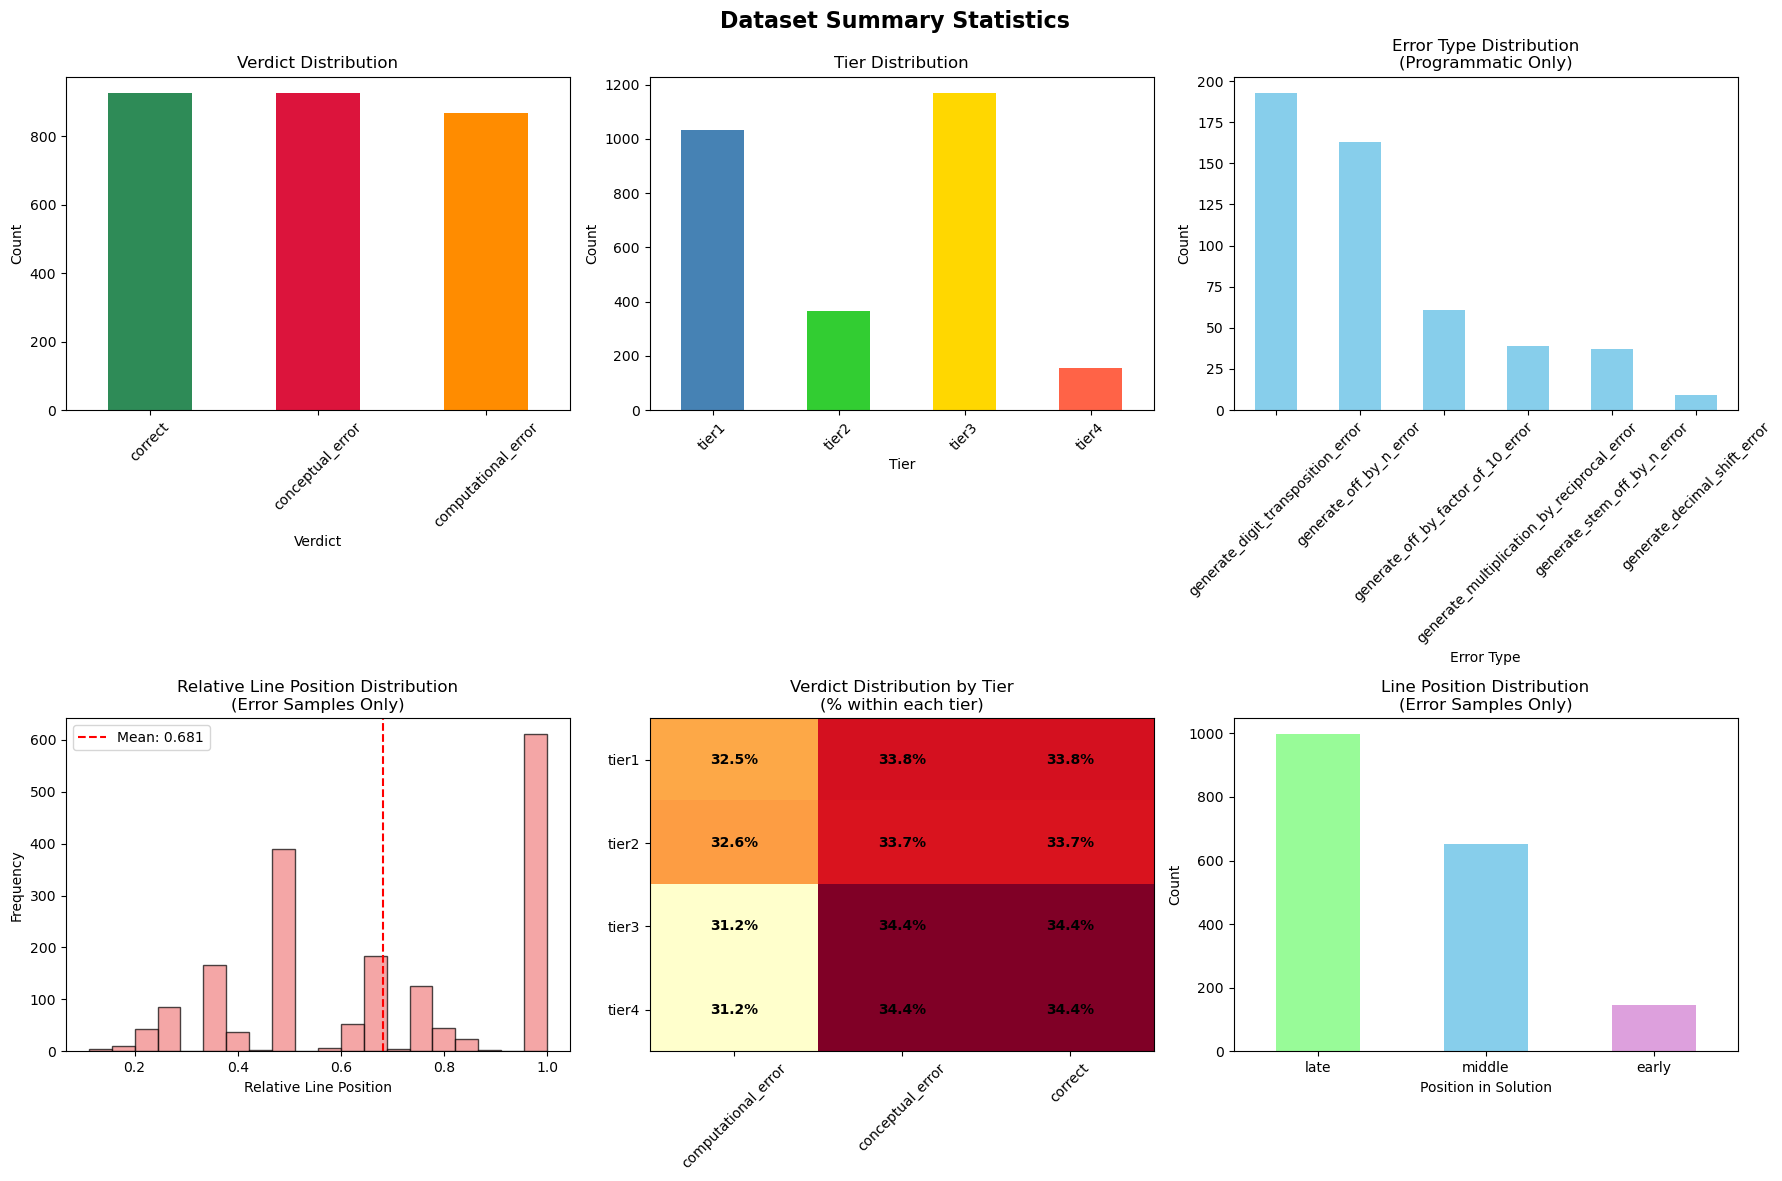


=== Final Dataset Summary ===
✓ Total samples: 2,724
✓ Unique problem indices: 928
✓ Average samples per problem: 2.9
✓ Problems with all 3 verdicts (perfect triplets): 868
✓ Problems with 2+ verdicts: 928

--- Sample Source Breakdown ---
Manual samples: 2,222
  - correct: 928
  - conceptual_error: 928
  - computational_error: 366
Programmatic samples: 502
  - computational_error: 502

🎉 Dataset preparation complete!
📊 Ready for training with 2,724 samples


In [10]:
# 1. Create the manual samples
print("=== Step 1: Creating Manual Samples ===")
manual_samples, missing_computational_indices = prepare_conceptual_and_correct_samples()
print(f"Created {len(manual_samples)} manual samples")
print(f"Missing computational errors for {len(missing_computational_indices)} indices")

# Analyze missing computational samples by tier
print("\n--- Missing Computational Samples by Tier ---")
missing_indices_df = pd.DataFrame({'index': missing_computational_indices})
missing_indices_df = add_tier_column(missing_indices_df, TIER_LISTS)
missing_by_tier = missing_indices_df['tier'].value_counts().sort_index()
print("Missing computational samples:")
for tier, count in missing_by_tier.items():
    print(f"  {tier}: {count}")

# Check availability in programmatic catalog by tier
print("\n--- Programmatic Catalog Coverage by Tier ---")
available_for_missing = programmatic_comp_df[
    programmatic_comp_df['index'].isin(missing_computational_indices)
]
available_by_tier = available_for_missing['tier'].value_counts().sort_index()
print("Available in programmatic catalog:")
for tier, count in available_by_tier.items():
    print(f"  {tier}: {count}")

# Calculate unfulfillable missing samples
print("\n--- Unfulfillable Missing Samples by Tier ---")
for tier in missing_by_tier.index:
    missing_count = missing_by_tier.get(tier, 0)
    available_count = available_by_tier.get(tier, 0)
    unfulfillable = missing_count - available_count
    if unfulfillable > 0:
        print(f"  {tier}: {unfulfillable} cannot be fulfilled")
    else:
        print(f"  {tier}: All {missing_count} can be fulfilled")

# 2. Create the programmatic computational samples
print("\n=== Step 2: Creating Programmatic Computational Samples ===")
programmatic_samples = sample_computational_errors_balanced(
    missing_computational_indices, 
    random_seed=RANDOM_SEED
)

# 3. Concatenate the two lists of samples
print("\n=== Step 3: Combining All Samples ===")
all_samples = manual_samples + programmatic_samples
print(f"Total dataset size: {len(all_samples)} samples")

# Calculate final missing by tier
final_missing_indices = set(missing_computational_indices) - set([s['index'] for s in programmatic_samples])
if final_missing_indices:
    print(f"\n--- Final Missing Computational Samples by Tier ---")
    final_missing_df = pd.DataFrame({'index': list(final_missing_indices)})
    final_missing_df = add_tier_column(final_missing_df, TIER_LISTS)
    final_missing_by_tier = final_missing_df['tier'].value_counts().sort_index()
    print("Still missing after programmatic sampling:")
    for tier, count in final_missing_by_tier.items():
        print(f"  {tier}: {count}")
else:
    print("\n✓ All missing computational errors successfully filled from programmatic catalog")

# 4. Summary statistics and plots
print("\n=== Step 4: Dataset Summary Statistics ===")

# Convert to DataFrame for easier analysis
df_all = pd.DataFrame(all_samples)

# Basic counts
print("\n--- Dataset Composition ---")
print(f"Total samples: {len(all_samples):,}")
print(f"Manual samples: {len(manual_samples):,}")
print(f"Programmatic samples: {len(programmatic_samples):,}")

# Verdict distribution
print("\n--- Verdict Distribution ---")
verdict_counts = df_all['verdict'].value_counts()
print(verdict_counts)
print("\nPercentages:")
for verdict, count in verdict_counts.items():
    pct = (count / len(all_samples)) * 100
    print(f"  {verdict}: {pct:.1f}%")

# Tier distribution
print("\n--- Tier Distribution ---")
tier_counts = df_all['tier'].value_counts().sort_index()
print(tier_counts)
print("\nPercentages:")
for tier, count in tier_counts.items():
    pct = (count / len(all_samples)) * 100
    print(f"  {tier}: {pct:.1f}%")

# Error type distribution (for programmatic samples)
print("\n--- Error Type Distribution (Programmatic Only) ---")
programmatic_df = pd.DataFrame(programmatic_samples)
if not programmatic_df.empty:
    error_type_counts = programmatic_df['error_type'].value_counts()
    print(error_type_counts)

# Cross-tabulation: Verdict by Tier
print("\n--- Cross-tabulation: Verdict by Tier ---")
crosstab = pd.crosstab(df_all['tier'], df_all['verdict'], margins=True)
print(crosstab)

# Relative line position statistics
print("\n--- Relative Line Position Statistics ---")
# Only for samples with errors (excluding correct samples)
error_samples = df_all[df_all['verdict'] != 'correct']
if not error_samples.empty:
    print(f"Mean relative line position: {error_samples['relative_line_position'].mean():.3f}")
    print(f"Median relative line position: {error_samples['relative_line_position'].median():.3f}")
    print(f"Std deviation: {error_samples['relative_line_position'].std():.3f}")

# Line position distribution
print("\n--- Line Position Distribution (Error Samples Only) ---")
if not error_samples.empty:
    error_samples_copy = error_samples.copy()
    error_samples_copy['line_pos_bin'] = pd.cut(
        error_samples_copy['relative_line_position'], 
        bins=[0, 0.33, 0.66, 1.0], 
        labels=['early', 'middle', 'late'],
        include_lowest=True
    )
    line_pos_counts = error_samples_copy['line_pos_bin'].value_counts()
    print(line_pos_counts)

# Create visualizations
import matplotlib.pyplot as plt

print("\n=== Generating Plots ===")

# Set up the plotting style
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Dataset Summary Statistics', fontsize=16, fontweight='bold')

# 1. Verdict Distribution
ax1 = axes[0, 0]
verdict_counts.plot(kind='bar', ax=ax1, color=['#2E8B57', '#DC143C', '#FF8C00'])
ax1.set_title('Verdict Distribution')
ax1.set_xlabel('Verdict')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# 2. Tier Distribution
ax2 = axes[0, 1]
tier_counts.plot(kind='bar', ax=ax2, color=['#4682B4', '#32CD32', '#FFD700', '#FF6347', '#9370DB'])
ax2.set_title('Tier Distribution')
ax2.set_xlabel('Tier')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

# 3. Error Type Distribution (Programmatic Only)
ax3 = axes[0, 2]
if not programmatic_df.empty:
    error_type_counts.plot(kind='bar', ax=ax3, color='skyblue')
    ax3.set_title('Error Type Distribution\n(Programmatic Only)')
    ax3.set_xlabel('Error Type')
    ax3.set_ylabel('Count')
    ax3.tick_params(axis='x', rotation=45)
else:
    ax3.text(0.5, 0.5, 'No Programmatic Samples', ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title('Error Type Distribution\n(Programmatic Only)')

# 4. Relative Line Position Histogram
ax4 = axes[1, 0]
if not error_samples.empty:
    ax4.hist(error_samples['relative_line_position'], bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
    ax4.set_title('Relative Line Position Distribution\n(Error Samples Only)')
    ax4.set_xlabel('Relative Line Position')
    ax4.set_ylabel('Frequency')
    ax4.axvline(error_samples['relative_line_position'].mean(), color='red', linestyle='--', 
                label=f'Mean: {error_samples["relative_line_position"].mean():.3f}')
    ax4.legend()

# 5. Verdict by Tier Heatmap
ax5 = axes[1, 1]
# Create percentage-based crosstab for better visualization
crosstab_pct = pd.crosstab(df_all['tier'], df_all['verdict'], normalize='index') * 100
im = ax5.imshow(crosstab_pct.values, cmap='YlOrRd', aspect='auto')
ax5.set_xticks(range(len(crosstab_pct.columns)))
ax5.set_yticks(range(len(crosstab_pct.index)))
ax5.set_xticklabels(crosstab_pct.columns, rotation=45)
ax5.set_yticklabels(crosstab_pct.index)
ax5.set_title('Verdict Distribution by Tier\n(% within each tier)')

# Add text annotations to heatmap
for i in range(len(crosstab_pct.index)):
    for j in range(len(crosstab_pct.columns)):
        text = ax5.text(j, i, f'{crosstab_pct.iloc[i, j]:.1f}%',
                       ha="center", va="center", color="black", fontweight='bold')

# 6. Line Position Bins
ax6 = axes[1, 2]
if not error_samples.empty:
    line_pos_counts.plot(kind='bar', ax=ax6, color=['#98FB98', '#87CEEB', '#DDA0DD'])
    ax6.set_title('Line Position Distribution\n(Error Samples Only)')
    ax6.set_xlabel('Position in Solution')
    ax6.set_ylabel('Count')
    ax6.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# Print final dataset information
print("\n=== Final Dataset Summary ===")
print(f"✓ Total samples: {len(all_samples):,}")
print(f"✓ Unique problem indices: {df_all['index'].nunique():,}")
print(f"✓ Average samples per problem: {len(all_samples) / df_all['index'].nunique():.1f}")

# Check for perfect balance in triplets
indices_with_all_three = df_all.groupby('index')['verdict'].nunique()
perfect_triplets = (indices_with_all_three == 3).sum()
partial_coverage = (indices_with_all_three >= 2).sum()

print(f"✓ Problems with all 3 verdicts (perfect triplets): {perfect_triplets:,}")
print(f"✓ Problems with 2+ verdicts: {partial_coverage:,}")

# Sample breakdown by source
manual_df = pd.DataFrame(manual_samples)
print(f"\n--- Sample Source Breakdown ---")
print(f"Manual samples: {len(manual_samples):,}")
if not manual_df.empty:
    manual_verdict_counts = manual_df['verdict'].value_counts()
    for verdict, count in manual_verdict_counts.items():
        print(f"  - {verdict}: {count:,}")

print(f"Programmatic samples: {len(programmatic_samples):,}")
if not programmatic_df.empty:
    prog_verdict_counts = programmatic_df['verdict'].value_counts()
    for verdict, count in prog_verdict_counts.items():
        print(f"  - {verdict}: {count:,}")

print(f"\n🎉 Dataset preparation complete!")
print(f"📊 Ready for training with {len(all_samples):,} samples")

In [21]:
print(all_samples[0]['messages'][2]['content'])  # Print the first sample to verify format

```json
{
  "verdict": "correct",
  "erroneous_line_number": "None",
  "explanation": "None"
}
```


In [24]:
for i in range(12):
    sample = all_samples[-i]
    user_content_sample = sample['messages'][1]['content']
    verdict_sample = sample['verdict']
    assistant_content_sample = sample['messages'][2]['content']
    # Parse the assistant content JSON
    assistant_content_sample = assistant_content_sample.strip('```json\n').strip('\n```')
    explanation_sample = json.loads(assistant_content_sample)['explanation']
    eln_sample = json.loads(assistant_content_sample)['erroneous_line_number']

    print(f"\nSample User Content:\n{user_content_sample}\n")
    print(f"Sample Verdict: {verdict_sample}\n")
    print(f"Sample Explanation: {explanation_sample}\n")
    print(f"Sample Erroneous Line Number: {eln_sample}\n")


Sample User Content:
### Question:
Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?

### Answer:
{
  "L1": "In the beginning, Betty has only 100 / 2 = $50.",
  "L2": "Betty's grandparents gave her 15 * 2 = $30.",
  "L3": "This means, Betty needs 100 - 50 - 30 - 15 = $5 more.",
  "FA": "5"
}

Sample Verdict: correct

Sample Explanation: None

Sample Erroneous Line Number: None


Sample User Content:
### Question:
Natalie has $26 to go shopping. She bought a jumper for $9, a T-shirt for $4, and a pair of heels for $5. How much money does Natalie have left?

### Answer:
{
  "L1": "The total cost of the clothes is $9 + $4 + $5 = $15.",
  "L2": "Natalie has $26 - $15 = $11 left.",
  "FA": "11"
}

Sample Verdict: computational_error

Sample Explanation: The result of this computatio

In [ ]:
# Choose 3 random problems, print original, conceptual-error, computational-error samples for each

import random
def print_sample_problems(samples: list[dict], num_samples: int = 3):
    """
    Prints a few sample problems from the dataset.
    
    Args:
        samples: List of sample dictionaries
        num_samples: Number of samples to print
    """
    print(f"\n--- Sample Problems ({num_samples}) ---")
    random_samples = random.sample(samples, min(num_samples, len(samples)))
    
    for sample in random_samples:
        index = sample['index']
        original_problem = GSM8K_DATASET[index]
        question = original_problem['question']
        
        print(f"\n### Index {index}:")
        # print(question)
        
        if sample['verdict'] == 'correct':
            # print("### Verdict: Correct")
            print("### Original Answer:")
            print(original_problem['answer'])
        else:
            user_content = sample['messages'][1]['content']
            assistant_content = sample['messages'][2]['content']
            # print("### Verdict:", sample['verdict'])
            print("### User Content:")
            print(user_content)
            print("### Assistant Content:")
            print(assistant_content)

print_sample_problems(all_samples, num_samples=3)


--- Sample Problems (3) ---

### Question 1038:
Marge planted 23 seeds in her garden. Five of the seeds never grew into plants. A third of the remaining seeds grew, but the plants were eaten by squirrels and rabbits. A third of the number of uneaten plants were strangled by weeds. Marge pulled two weeds, but liked the flowers on one weed and let the plant grow as part of her garden. How many plants did Marge end up with?
### Verdict: computational_error
### User Content:
### Question:
Marge planted 23 seeds in her garden. Five of the seeds never grew into plants. A third of the remaining seeds grew, but the plants were eaten by squirrels and rabbits. A third of the number of uneaten plants were strangled by weeds. Marge pulled two weeds, but liked the flowers on one weed and let the plant grow as part of her garden. How many plants did Marge end up with?

### Answer:
{
  "L1": "Marge had 23 - 5 = 18 seeds grow into plants.",
  "L2": "Rabbits ate 18 / 3 = 6 plants.",
  "L3": "There wer

In [11]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import json

# Check if MPS (Metal Performance Shaders) is available on Apple Silicon
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


In [12]:
# Load model and tokenizer with optimizations for Apple Silicon
model_name = "microsoft/Phi-4-mini-instruct"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load model with optimizations for Mac
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,  # Use half precision to save memory
    device_map=None,  # Don't use device mapping
    attn_implementation="eager",  # Use eager attention (more compatible)
    trust_remote_code=True
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [13]:
model

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(200064, 3072, padding_idx=199999)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3Attention(
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear(in_features=3072, out_features=5120, bias=False)
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLU()
        )
        (input_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (norm): Phi3RMSNorm((3072,), eps=1e-05)
    (rotary_emb): Phi3RotaryEmbedding()
  )
  (lm_head): Linear(in_features=3072, out_features=20006

In [14]:
# After loading the model successfully, save it locally
import os

# Create a local models directory
local_model_dir = PROJECT_ROOT / "models" / "phi-4-mini-instruct"
local_model_dir.mkdir(parents=True, exist_ok=True)

print(f"Saving model to: {local_model_dir}")

# Save the model and tokenizer
model.save_pretrained(local_model_dir)
tokenizer.save_pretrained(local_model_dir)

print("✓ Model and tokenizer saved locally!")

Saving model to: /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math/models/phi-4-mini-instruct


KeyboardInterrupt: 

In [ ]:
del model
del tokenizer

In [ ]:
# Move model to MPS if available
if device == "mps":
    model = model.to("cpu")
    model = model.to(device)

print(f"Model loaded successfully on {device}")
print(f"Model memory footprint: ~{model.get_memory_footprint() / 1e9:.1f} GB")

You shouldn't move a model that is dispatched using accelerate hooks.


RuntimeError: You can't move a model that has some modules offloaded to cpu or disk.

In [ ]:
# def test_inference(sample_data):
#     """Test inference on a single sample from your dataset"""
    
#     # Create inference sample (without assistant message)
#     inference_sample = {
#         "messages": [
#             {"role": "system", "content": sample_data["messages"][0]["content"]},
#             {"role": "user", "content": sample_data["messages"][1]["content"]}
#             # No assistant message for inference
#         ]
#     }
    
#     # Apply chat template for generation
#     input_text = tokenizer.apply_chat_template(
#         inference_sample["messages"],
#         tokenize=False,
#         add_generation_prompt=True  # Add assistant prompt for generation
#     )
    
#     # Tokenize and generate
#     inputs = tokenizer(input_text, return_tensors="pt")
    
#     # Move inputs to same device as model
#     if device == "mps":
#         inputs = {k: v.to(device) for k, v in inputs.items()}
    
#     # Generate with conservative settings for stability
#     with torch.no_grad():
#         outputs = model.generate(
#             **inputs,
#             max_new_tokens=200,
#             temperature=0.1,  # Low temperature for more deterministic output
#             do_sample=True,
#             pad_token_id=tokenizer.eos_token_id,
#             eos_token_id=tokenizer.eos_token_id
#         )
    
#     # Decode the generated text
#     generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
#     # Extract just the assistant's response part
#     assistant_response = generated_text.split("<|assistant|>")[-1].strip()
    
#     return assistant_response

# def parse_assistant_response(response_text: str) -> dict:
#     """Extract JSON from fenced code block in assistant response."""
#     import re
#     pattern = r'```json\s*\n(.*?)\n```'
#     match = re.search(pattern, response_text, re.DOTALL)
    
#     if match:
#         json_str = match.group(1)
#         try:
#             return json.loads(json_str)
#         except json.JSONDecodeError as e:
#             print(f"JSON parsing error: {e}")
#             return {"error": "Invalid JSON", "raw_response": response_text}
#     else:
#         # Fallback: try to parse the entire response as JSON
#         try:
#             return json.loads(response_text)
#         except json.JSONDecodeError:
#             return {"error": "No JSON found", "raw_response": response_text}

# # Test with a sample from your dataset
# if len(all_samples) > 0:
#     test_sample = all_samples[0]  # Use first sample
#     print("Testing inference on sample:")
#     print(f"Index: {test_sample['index']}")
#     print(f"Expected verdict: {test_sample['verdict']}")
#     print("\n" + "="*50)
    
#     # Run inference
#     response = test_inference(test_sample)
#     print("Raw model response:")
#     print(response)
#     print("\n" + "="*50)
    
#     # Parse response
#     parsed = parse_assistant_response(response)
#     print("Parsed response:")
#     print(json.dumps(parsed, indent=2))
    
#     # Compare with expected
#     print("\n" + "="*50)
#     print("Expected assistant content:")
#     print(test_sample["messages"][2]["content"])

In [ ]:
# # Additional memory optimizations if needed
# model = AutoModelForCausalLM.from_pretrained(
#     model_name,
#     torch_dtype=torch.float16,
#     device_map="auto",
#     attn_implementation="eager",
#     trust_remote_code=True,
#     low_cpu_mem_usage=True,  # Reduce CPU memory during loading
#     offload_folder="./offload"  # Offload to disk if needed
# )

# # Enable memory efficient attention if available
# try:
#     model.config.use_memory_efficient_attention = True
# except:
#     pass

In [ ]:
# # Your dataset will already be in the right format
# dataset = Dataset.from_list(samples)

# # The tokenizer will automatically apply chat template
# def tokenize_function(examples):
#     tokenized = tokenizer.apply_chat_template(
#         examples["messages"], 
#         tokenize=True, 
#         add_generation_prompt=False,  # Include assistant response for training
#         return_tensors="pt"
#     )
#     return {"input_ids": tokenized}

# tokenized_dataset = dataset.map(tokenize_function)

In [ ]:
# # Create inference sample (without assistant message)
# inference_sample = {
#     "messages": [
#         {"role": "system", "content": SYSTEM_MESSAGE},
#         {"role": "user", "content": user_content}
#         # No assistant message for inference
#     ]
# }

# # Apply chat template for generation
# input_text = tokenizer.apply_chat_template(
#     inference_sample["messages"],
#     tokenize=False,
#     add_generation_prompt=True  # Add assistant prompt for generation
# )

# # Tokenize and generate
# inputs = tokenizer(input_text, return_tensors="pt")
# outputs = model.generate(**inputs, max_new_tokens=500)

In [ ]:
# def parse_assistant_response(response_text: str) -> dict:
#     """Extract JSON from fenced code block in assistant response."""
#     # Look for json fenced code block
#     import re
#     pattern = r'```json\s*\n(.*?)\n```'
#     match = re.search(pattern, response_text, re.DOTALL)
    
#     if match:
#         json_str = match.group(1)
#         return json.loads(json_str)
#     else:
#         # Fallback: try to parse the entire response as JSON
#         return json.loads(response_text)

# # During inference:
# generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
# # Extract just the assistant's response part
# assistant_response = generated_text.split("<|assistant|>")[-1]
# parsed_result = parse_assistant_response(assistant_response)